# Imports

In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Login 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Basic GAN (FF+ MNIST)

## Training Setup

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# Device setting
D = D.to(device)
G = G.to(device)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

## Load Mnist dataset (and data loader)

In [5]:
# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5,), 
                                     std=(0.5,))])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

total_step = len(data_loader)

0it [00:00, ?it/s]

9920512it [00:00, 10891290.89it/s]                           


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 164634.22it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw


1654784it [00:00, 2671396.39it/s]                           
8192it [00:00, 62933.15it/s]            


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw
Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!


## Load Pretrained Model (Optional)

In [6]:
# Load D and G
D.load_state_dict(torch.load('gdrive/My Drive/fine-tuning-generators/ff+mnist/D_200.ckpt'))
G.load_state_dict(torch.load('gdrive/My Drive/fine-tuning-generators/ff+mnist/G_200.ckpt'))

<All keys matched successfully>

## Main Training Loop

In [16]:
g_loss_list = []
e = []
d_loss_real_list = []
d_loss_fake_list = []
for epoch in range(num_epochs):
    e.append(epoch)
    for i, (images, _) in enumerate(data_loader):
        print(images.shape)
        images = images.reshape(batch_size, -1).to(device)
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        if i == total_step - 1:
            d_loss_real_list.append(d_loss_real)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        if i == total_step - 1:
            d_loss_fake_list.append(d_loss_fake)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        if i == total_step - 1:
            g_loss_list.append(g_loss)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    
    # Reshape sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)

    fake_images_clone = fake_images.clone()
    im = denorm(fake_images_clone[0]).cpu().detach().numpy()
    im = (im * 255).astype(np.uint8)
    im = im.reshape((28, 28))
    imgplot = plt.imshow(im, cmap='gray')
    plt.show()

    plt.plot(e, d_loss_real_list, 'b-', label = 'd_loss_real')
    plt.plot(e, d_loss_fake_list, 'g-', label = 'd_loss_fake') 
    plt.plot(e, g_loss_list, 'r-', label = 'g_loss')
    plt.legend()
    plt.show()

# Save the model checkpoints 
torch.save(G.state_dict(), 'gdrive/My Drive/fine-tuning-generators/ff+mnist/G_200.ckpt')
torch.save(D.state_dict(), 'gdrive/My Drive/fine-tuning-generators/ff+mnist/D_200.ckpt')

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([10

KeyboardInterrupt: ignored

## Create Augmented Dataset

In [0]:
# Device setting
D = D.to(device)
G = G.to(device)

# Create an equal number of fake images
aug_size = len(mnist)
z = torch.randn(aug_size, latent_size).to(device)
fake_dataset_images = G(z)
fake_dataset_labels = torch.zeros(aug_size, 1)
fake_dataset = (fake_dataset_images.clone().cpu().detach(), fake_dataset_labels.clone().cpu().detach())

# Ugly code to pry out data from an existing dataset
original_data = np.zeros((len(mnist), image_size))
for i in range(len(mnist)):
  original_data[i,:] = mnist[i][0].reshape(image_size,)


In [0]:
# Create augmented dataset
class AugDataset(torch.utils.data.Dataset):
    def __init__(self, original_data, generated_data):
        # Load Data 
        self.x_train = np.vstack((original_data, generated_data[0].numpy()))
      
        self.y_train = np.vstack((np.ones(((original_data.shape[0], 1))), np.zeros(((generated_data[0].numpy().shape[0], 1)))))

    def __getitem__(self, index):
        return (self.x_train[index], self.y_train[index])

    def __len__(self):
        return self.x_train.shape[0]

# Init dataset
ds = AugDataset(original_data, fake_dataset)

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

# Create Classifier

In [0]:
# Fully connected neural network with the same architecture as the Discriminator
class NeuralNet(nn.Module):

    def __init__(self, image_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(image_size, hidden_size) 
        self.relu1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.relu2 = nn.LeakyReLU(0.2)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.sig = nn.Sigmoid()

        self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sig(out)
        return out

# Create model
clf = NeuralNet(image_size, hidden_size).to(device)

## Train Classifier

In [0]:
# Train the model
num_epochs_clf = 1
total_step = len(train_loader)
for epoch in range(num_epochs_clf):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(batch_size, -1).to(device)
        #images = images.reshape(-1, 28*28).to(device)
        labels = labels.reshape(batch_size, -1).to(device)
        
        # Forward pass
        outputs = clf(images.float())
        loss = clf.criterion(outputs, labels.float())
        
        # Backward and optimize
        clf.optimizer.zero_grad()
        loss.backward()
        clf.optimizer.step()

        if i == 300:
          break
        
        if (i+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs_clf, i+1, total_step, loss.item()))

## Test Classifier

In [9]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
clf = D
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(batch_size, -1).to(device)
        #images = images.reshape(-1, 28*28).to(device)
        labels = labels.reshape(batch_size, -1).to(device)

        outputs = clf(images.float())
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        predicted_labels = torch.where(outputs > 0.5, real_labels, fake_labels)


        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Accuracy of the network on the 24000 test images: 75.11666666666666 %


# Fine Tuning

In [0]:
def train_gan(D, G, D_save_loc, G_save_loc, d_optimizer, g_optimizer, latent_size, data_loader, num_epochs, batch_size, criterion, device):
    total_step = len(data_loader)
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(data_loader):
            images = images.reshape(batch_size, -1).to(device)
            
            # Create the labels which are later used as input for the BCE loss
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            '''
            # ================================================================== #
            #                      Train the discriminator                       #
            # ================================================================== #

            # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
            # Second term of the loss is always zero since real_labels == 1
            outputs = D(images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs
            
            
            # Compute BCELoss using fake images
            # First term of the loss is always zero since fake_labels == 0
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs
            
            # Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            reset_grad()
            d_loss.backward()
            d_optimizer.step()
            '''
            # ================================================================== #
            #                        Train the generator                         #
            # ================================================================== #

            # Compute loss with fake images
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
            
            # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
            # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
            g_loss = criterion(outputs, real_labels)
            
            # Backprop and optimize
            reset_grad()
            g_loss.backward()
            g_optimizer.step()
            
            if (i+1) % 200 == 0:
                print('Epoch [{}/{}], Step [{}/{}], g_loss: {:.4f}' 
                      .format(epoch, num_epochs, i+1, total_step, g_loss.item(), 
                              ))
        
        
        # Reshape sampled images
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)

        fake_images_clone = fake_images.clone()
        im = denorm(fake_images_clone[0]).cpu().detach().numpy()
        im = (im * 255).astype(np.uint8)
        im = im.reshape((28, 28))
        imgplot = plt.imshow(im, cmap='gray')
        plt.show()

    # Save the model checkpoints 
    torch.save(G.state_dict(), G_save_loc)
    torch.save(D.state_dict(), D_save_loc)

    return D, G

Epoch [0/200], Step [200/600], g_loss: 0.0001
Epoch [0/200], Step [400/600], g_loss: 0.0002
Epoch [0/200], Step [600/600], g_loss: 0.0001


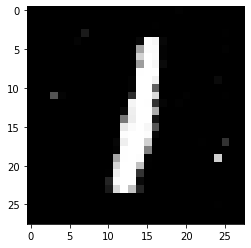

Epoch [1/200], Step [200/600], g_loss: 0.0001
Epoch [1/200], Step [400/600], g_loss: 0.0002
Epoch [1/200], Step [600/600], g_loss: 0.0000


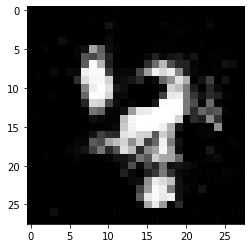

Epoch [2/200], Step [200/600], g_loss: 0.0001
Epoch [2/200], Step [400/600], g_loss: 0.0000
Epoch [2/200], Step [600/600], g_loss: 0.0000


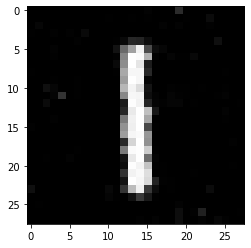

Epoch [3/200], Step [200/600], g_loss: 0.0001
Epoch [3/200], Step [400/600], g_loss: 0.0000
Epoch [3/200], Step [600/600], g_loss: 0.0000


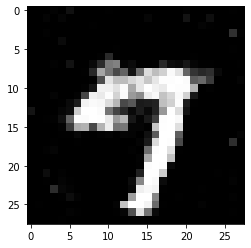

Epoch [4/200], Step [200/600], g_loss: 0.0000
Epoch [4/200], Step [400/600], g_loss: 0.0000
Epoch [4/200], Step [600/600], g_loss: 0.0001


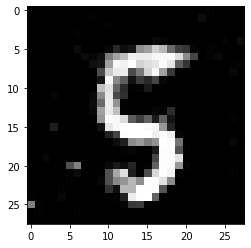

Epoch [5/200], Step [200/600], g_loss: 0.0000
Epoch [5/200], Step [400/600], g_loss: 0.0000
Epoch [5/200], Step [600/600], g_loss: 0.0000


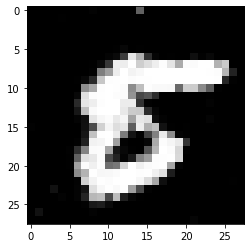

Epoch [6/200], Step [200/600], g_loss: 0.0000
Epoch [6/200], Step [400/600], g_loss: 0.0000
Epoch [6/200], Step [600/600], g_loss: 0.0000


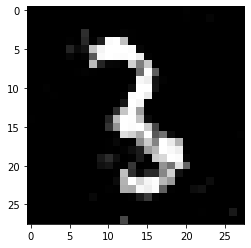

KeyboardInterrupt: ignored

In [29]:
D, G = train_gan(clf, G, 'gdrive/My Drive/fine-tuning-generators/ff+mnist/D_200+ft1.ckpt', 'gdrive/My Drive/fine-tuning-generators/ff+mnist/G_200+ft1.ckpt', d_optimizer, g_optimizer, latent_size, data_loader, num_epochs, batch_size, criterion, device)